# Stroke prediction 2 - more age bands

Can we predict the number of admissions for each MSOA using the patient demographics?

This notebook uses more age bands (0-64, 65-69, 70-74, 75-79, and 80+ years old), Index of Mean Deprivation, and health bands (good health, fair health, and bad health).

## Code setup

In [1]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Patient demographics by MSOA:

In [2]:
path_to_msoa_stats = os.path.join('data', 'msoa_collated.csv')

df_stats_old = pl.read_csv(path_to_msoa_stats)

In [3]:
df_stats_old.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761


Link MSOA names and codes:

In [4]:
path_to_msoa = os.path.join('data', 'Output_Area_to_LSOA_to_MSOA_to_Local_Authority_District_(December_2017)_Lookup_with_Area_Classifications_in_Great_Britain.csv')

df_msoa_names_codes = pl.read_csv(path_to_msoa)

In [5]:
df_msoa_names_codes = df_msoa_names_codes.unique(subset='MSOA11CD')[['MSOA11CD', 'MSOA11NM']]

In [6]:
df_msoa_names_codes

MSOA11CD,MSOA11NM
str,str
"""E02005649""","""Kettering 011"""
"""E02000767""","""Redbridge 017"""
"""E02001090""","""Manchester 046"""
"""E02003677""","""Chiltern 002"""
"""E02004425""","""Basildon 002"""
…,…
"""E02003874""","""Cheshire West and Chester 002"""
"""E02005353""","""Charnwood 009"""
"""S02001661""","""Balgreen and Roseburn"""


In [7]:
df_stats_old = df_stats_old.join(df_msoa_names_codes, left_on='MSOA', right_on='MSOA11NM', how='left')

df_stats_old.head(3)

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534"""
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535"""
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536"""


Newer stats dataframe with age band info:

In [8]:
path_to_msoa_stats = os.path.join('data', 'collated_data_regional_msoa11cd.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [9]:
df_stats.head()

msoa11cd,polygon_area_km2,population_density,income_domain_weighted_mean,imd_weighted_mean,weighted_ivt_time,mt_time_weighted_mean,ivt_time_weighted_mean,mt_transfer_time_weighted_mean,ethnic_group_other_than_white_british,ethnic_group_all_categories_ethnic_group,ethnic_minority_proportion,bad_or_very_bad_health,all_categories_general_health,bad_health_proportion,long_term_health_count,all_categories_long_term_health_problem_or_disability,long_term_health_proportion,age_65_plus_count,population_all,age_65_plus_proportion,age_band_all_0,age_0_proportion,age_band_all_5,age_5_proportion,age_band_all_10,age_10_proportion,age_band_all_15,age_15_proportion,age_band_all_20,age_20_proportion,age_band_all_25,age_25_proportion,age_band_all_30,age_30_proportion,age_band_all_35,age_35_proportion,age_band_all_40,age_40_proportion,age_band_all_45,age_45_proportion,age_band_all_50,age_50_proportion,age_band_all_55,age_55_proportion,age_band_all_60,age_60_proportion,age_band_all_65,age_65_proportion,age_band_all_70,age_70_proportion,age_band_all_75,age_75_proportion,age_band_all_80,age_80_proportion,age_band_all_85,age_85_proportion,age_band_all_90,age_90_proportion,rural_False,rural_True,proportion_rural,over_65_within_30_False,over_65_within_30_True,proportion_over_65_within_30,closest_is_mt_False,closest_is_mt_True,proportion_closest_is_mt
str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""E02000001""",7.4935,1459.6557,0.0693,15.4842,10.9293,10.7663,10.7663,0.0,3132,7375,0.4247,246,7375,0.0334,835,7187,0.1162,1731,10938,0.1583,474,0.0433,646,0.0591,465,0.0425,455,0.0416,1061,0.097,1445,0.1321,795,0.0727,680,0.0622,538,0.0492,663,0.0606,764,0.0698,672,0.0614,549,0.0502,508,0.0464,474,0.0433,300,0.0274,217,0.0198,116,0.0106,116,0.0106,10938.0,0.0,0.0,0.0,1731.0,1.0,0.0,10938.0,1.0
"""E02000002""",5.603,1378.9128,0.2165,34.8123,13.3056,13.2008,13.2008,0.0,2861,6775,0.4223,495,6775,0.0731,1346,6724,0.2002,979,7726,0.1267,674,0.0872,688,0.089,640,0.0828,527,0.0682,409,0.0529,528,0.0683,588,0.0761,551,0.0713,537,0.0695,494,0.0639,432,0.0559,404,0.0523,275,0.0356,231,0.0299,178,0.023,209,0.0271,166,0.0215,92,0.0119,103,0.0133,7726.0,0.0,0.0,0.0,979.0,1.0,0.0,7726.0,1.0
"""E02000003""",5.5425,2029.0451,0.1412,25.2469,10.2465,10.2794,10.2794,0.0,5291,10045,0.5267,521,10045,0.0519,1590,10033,0.1585,1284,11246,0.1142,956,0.085,860,0.0765,740,0.0658,644,0.0573,632,0.0562,865,0.0769,991,0.0881,950,0.0845,794,0.0706,726,0.0646,643,0.0572,604,0.0537,557,0.0495,349,0.031,336,0.0299,219,0.0195,183,0.0163,120,0.0107,77,0.0068,11246.0,0.0,0.0,0.0,1284.0,1.0,0.0,11246.0,1.0
"""E02000004""",6.4333,1033.0652,0.1402,23.8576,9.3787,9.3055,9.3055,0.0,1461,6182,0.2363,378,6182,0.0611,1016,5937,0.1711,1008,6646,0.1517,461,0.0694,476,0.0716,381,0.0573,385,0.0579,478,0.0719,555,0.0835,458,0.0689,427,0.0642,354,0.0533,419,0.063,422,0.0635,416,0.0626,406,0.0611,236,0.0355,238,0.0358,192,0.0289,142,0.0214,88,0.0132,112,0.0169,6646.0,0.0,0.0,0.0,1008.0,1.0,0.0,6646.0,1.0
"""E02000005""",3.0652,3438.5836,0.1571,29.6949,10.1,10.1,10.1,0.0,3534,8562,0.4128,528,8562,0.0617,1435,8562,0.1676,920,10540,0.0873,990,0.0939,923,0.0876,897,0.0851,720,0.0683,568,0.0539,728,0.0691,860,0.0816,887,0.0842,782,0.0742,692,0.0657,633,0.0601,547,0.0519,393,0.0373,268,0.0254,222,0.0211,169,0.016,124,0.0118,82,0.0078,55,0.0052,10540.0,0.0,0.0,0.0,920.0,1.0,0.0,10540.0,1.0


Only keep columns that match other MSOA dataframe:

In [10]:
cols_to_keep = [
    'msoa11cd',
    'age_0_proportion',
    'age_5_proportion',
    'age_10_proportion',
    'age_15_proportion',
    'age_20_proportion',
    'age_25_proportion',
    'age_30_proportion',
    'age_35_proportion',
    'age_40_proportion',
    'age_45_proportion',
    'age_50_proportion',
    'age_55_proportion',
    'age_60_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_80_proportion',
    'age_85_proportion',
    'age_90_proportion',
]

In [11]:
df_stats = df_stats[cols_to_keep]

Merge together:

In [12]:
df_stats = df_stats_old.join(df_stats, left_on='MSOA11CD', right_on='msoa11cd', how='left')

In [13]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_0_proportion,age_5_proportion,age_10_proportion,age_15_proportion,age_20_proportion,age_25_proportion,age_30_proportion,age_35_proportion,age_40_proportion,age_45_proportion,age_50_proportion,age_55_proportion,age_60_proportion,age_65_proportion,age_70_proportion,age_75_proportion,age_80_proportion,age_85_proportion,age_90_proportion
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534""",0.0515,0.0708,0.0614,0.0573,0.0449,0.0409,0.0508,0.0652,0.0682,0.0714,0.0745,0.0748,0.0555,0.0559,0.0528,0.0422,0.0322,0.0177,0.0121
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535""",0.0518,0.074,0.0638,0.0454,0.03,0.0369,0.0386,0.0586,0.0678,0.0836,0.0691,0.0674,0.0597,0.0578,0.0774,0.0492,0.0369,0.0206,0.0117
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536""",0.0461,0.0621,0.0697,0.0652,0.0404,0.0389,0.0501,0.0603,0.0643,0.0681,0.0753,0.0685,0.0639,0.0609,0.0582,0.0421,0.0385,0.0188,0.0088
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011,"""E02006537""",0.0616,0.0719,0.0608,0.0537,0.0463,0.0564,0.0611,0.0602,0.0696,0.072,0.0747,0.0679,0.0529,0.0465,0.0438,0.0367,0.0318,0.0213,0.0107
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761,"""E02006538""",0.0527,0.0618,0.0541,0.0367,0.0414,0.0517,0.0503,0.056,0.0666,0.081,0.0762,0.0742,0.0616,0.0597,0.067,0.0425,0.0313,0.0216,0.0133


Merge age bands under 65:

In [14]:
ages_to_merge = [
    'age_0_proportion',
    'age_5_proportion',
    'age_10_proportion',
    'age_15_proportion',
    'age_20_proportion',
    'age_25_proportion',
    'age_30_proportion',
    'age_35_proportion',
    'age_40_proportion',
    'age_45_proportion',
    'age_50_proportion',
    'age_55_proportion',
    'age_60_proportion',
    # 'age_65_proportion',
]

df_stats = df_stats.insert_column(-1, pl.Series('age_less65_proportion', df_stats[ages_to_merge].sum_horizontal()))

df_stats = df_stats.drop(ages_to_merge)

Merge age bands over 80:

In [15]:
ages_to_merge = [
    'age_80_proportion',
    'age_85_proportion',
    'age_90_proportion',
]

df_stats = df_stats.insert_column(-1, pl.Series('age_over80_proportion', df_stats[ages_to_merge].sum_horizontal()))

df_stats = df_stats.drop(ages_to_merge)

In [16]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Drop old proportion age bands to prevent confusion:

In [18]:
df_stats = df_stats.drop(['prop_0-64', 'prop_65-79', 'prop_80+', '0-64', '65-79', '80+'])

Check sum of admissions for Welsh areas:

In [19]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Welsh data is always zero so remove it.

In [20]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

In [21]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


## Check data stats

Check the range of values in the data and whether they seem correlated with admissions numbers.

Check for these columns which will be used in the model:

In [24]:
cols_to_check = [
    'age_less65_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_over80_proportion',
    'IMD2019Score',
    'prop_good_health',
    'prop_fair health',
    'prop_bad health',
]

Calculate some statistics:

In [25]:
dict_stats = {}
for prop in cols_to_check:
    p = df_stats[prop]
    d = df_stats['admissions'] / p
    c = np.cov(df_stats['admissions'], p)[0][1]

    dict_stats[prop] = {}
    dict_stats[prop]['mean'] = p.mean()
    dict_stats[prop]['std'] = p.std()
    dict_stats[prop]['admissions_div_prop_mean'] = d.mean()
    dict_stats[prop]['admissions_div_prop_std'] = d.std()
    dict_stats[prop]['cov'] = c

Display them in a DataFrame:

In [26]:
df_stats_stats = pl.from_dicts(list(dict_stats.values()))

# df_stats_stats['props'] = list(dict_stats.keys())
df_stats_stats.insert_column(index=0, column=pl.Series('prop', list(dict_stats.keys())))

prop,mean,std,admissions_div_prop_mean,admissions_div_prop_std,cov
str,f64,f64,f64,f64,f64
"""age_less65_proportion""",0.80842,0.070685,15.098626,6.613342,-0.141263
"""age_65_proportion""",0.050779,0.015745,250.397469,106.145893,0.02658
"""age_70_proportion""",0.05164,0.020377,263.073252,138.466845,0.036406
"""age_75_proportion""",0.036904,0.015589,374.498573,202.338077,0.029595
"""age_over80_proportion""",0.052259,0.022518,261.623473,137.179204,0.048683
"""IMD2019Score""",21.638473,13.244139,0.801173,0.649843,2.201578
"""prop_good_health""",0.812839,0.043983,14.834584,6.005458,-0.079966
"""prop_fair health""",0.132006,0.026105,90.672826,30.600641,0.054816
"""prop_bad health""",0.055154,0.020116,235.202158,102.76941,0.02515


Scatter the data to see by eye whether there is a correlation with admissions numbers.

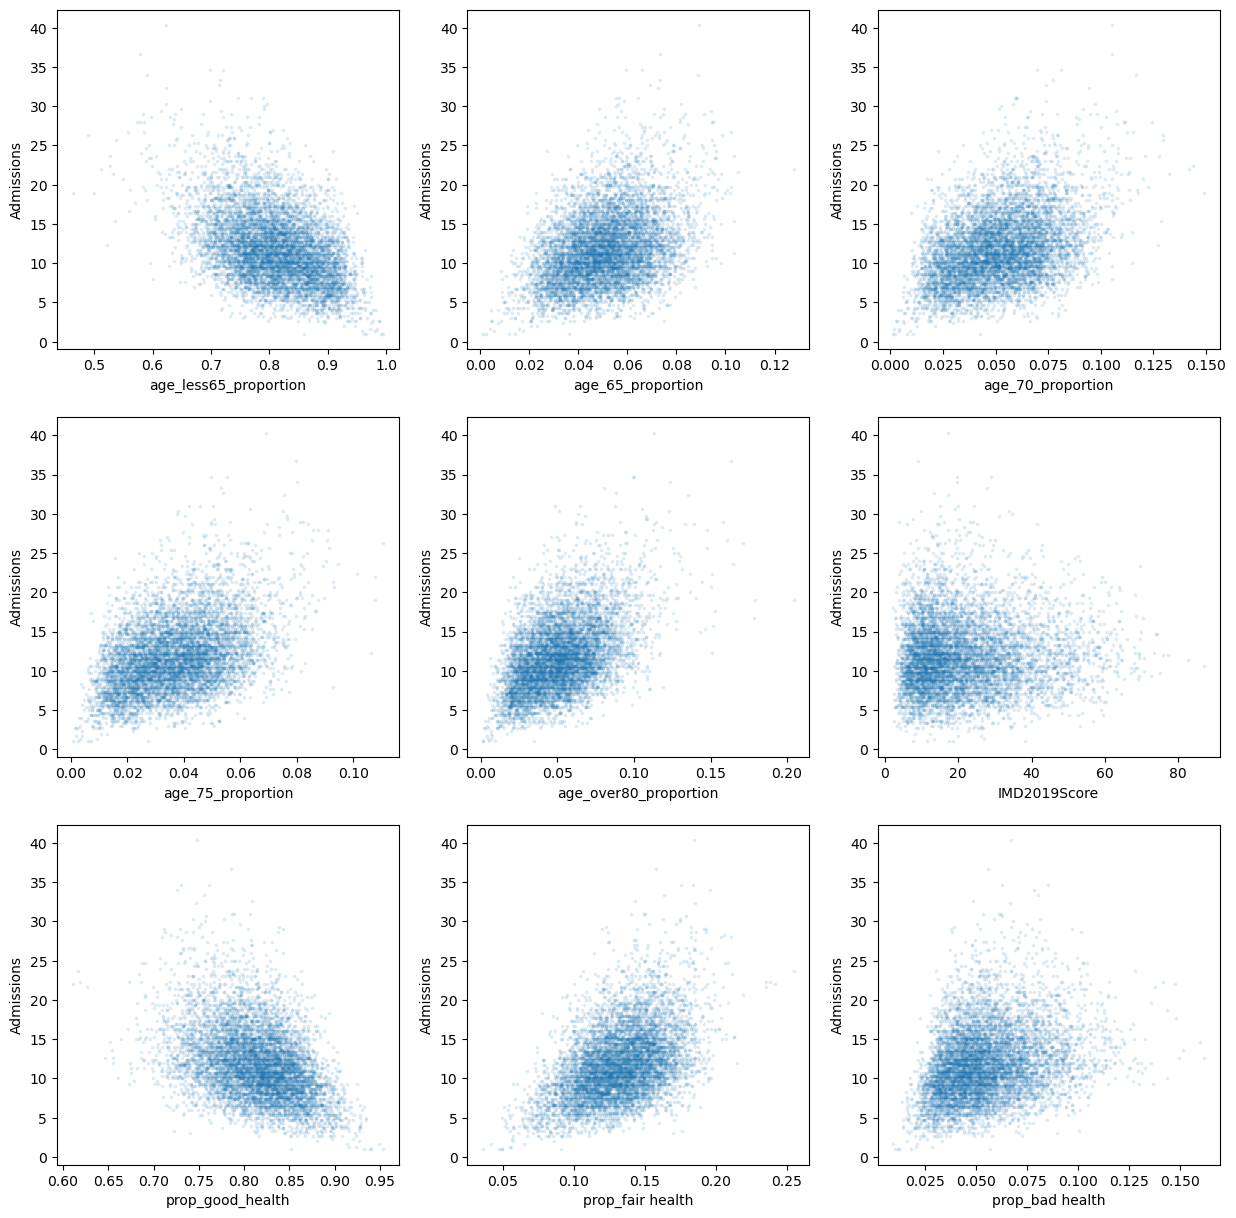

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for c, col in enumerate(cols_to_check):
    ax = axs[c // 3, c % 3]
    ax.scatter(df_stats[col], df_stats['admissions'], s=3, alpha=0.1)
    ax.set_xlabel(col)
    ax.set_ylabel('Admissions')
plt.show()

## Set up functions

This multiplies coefficients by the data:

In [28]:
def predict_admissions(x_lists, coeffs):
    """
    x_lists: np.array.
    coeffs: np.array.
    
    Have to have same number of coeffs as x_lists.
    """
    # Predicted admissions:
    yhat = (x_lists * coeffs.reshape(len(coeffs), 1)).sum(axis=0)
    return yhat
    

This calculates the sum of the square of the differences between predicted and actual admission numbers:

In [29]:
def find_square_residuals(yhat, y):
    # Difference from actual:
    sqres = (yhat - y)**2.0
    # Sum of differences:
    sum_sqres = sqres.sum()
    return sum_sqres

This makes a quick plot of predicted vs admissions numbers:

In [30]:
def plot_y_vs_yhat(y, yhat):
    fig, ax = plt.subplots()

    # Draw the data:
    ax.scatter(y, yhat, s=2, alpha=0.1)

    # Draw a line diagonally:
    ax.set_aspect('equal')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    vmin = min([xmin, ymin])
    vmax = max([xmax, ymax])
    ax.plot([0, vmax], [0, vmax], color='k', linewidth=1)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    
    plt.show()

## Linear regression

Use the `statsmodels` package to create Ordinary Least Squares linear regression models for certain parts of the data.

### Age bands only

In [31]:
age_props = [
    'age_less65_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_over80_proportion',
]

In [32]:
y = df_stats['admissions'].to_numpy()
X = df_stats[age_props].to_numpy()

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                          1.267e+04
Date:                Wed, 22 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:07:09   Log-Likelihood:                         -18989.
No. Observations:                6790   AIC:                                  3.799e+04
Df Residuals:                    6785   BIC:                                  3.802e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
age_coeffs_lr = results.params

age_coeffs_lr

array([  6.55799616,  35.44578406, -15.72407045,  -2.08942056,
       109.27678479])

### IMD and age bands

In [34]:
y = df_stats['admissions'].to_numpy()
X = df_stats[age_props + ['IMD2019Score']].to_numpy()

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                          1.186e+04
Date:                Wed, 22 Jan 2025   Prob (F-statistic):                        0.00
Time:                        16:07:49   Log-Likelihood:                         -18630.
No. Observations:                6790   AIC:                                  3.727e+04
Df Residuals:                    6784   BIC:                                  3.731e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [35]:
imd_age_coeffs_lr = results.params

imd_age_coeffs_lr

array([2.93606694e+00, 7.15262873e+00, 7.41993595e+00, 8.03366258e+00,
       1.18277084e+02, 1.07477732e-01])

### Health, IMD and age bands

In [36]:
y = df_stats['admissions'].to_numpy()
X = df_stats[age_props + ['IMD2019Score', 'prop_good_health', 'prop_fair health', 'prop_bad health']].to_numpy()

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     439.1
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:07:52   Log-Likelihood:                -18460.
No. Observations:                6790   AIC:                         3.694e+04
Df Residuals:                    6781   BIC:                         3.700e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           321.9385    352.053      0.914      0.3

In [37]:
health_imd_age_coeffs_lr = results.params

health_imd_age_coeffs_lr

array([ 3.21938545e+02,  3.10057476e+02,  3.24251285e+02,  3.03290091e+02,
        4.12706860e+02, -2.55726867e-02, -3.21015363e+02, -2.75239194e+02,
       -2.85867330e+02])

## Optimiser

### Age coefficients

Manually change the coeffs until there's something that resembles a fit to a straight line:

In [ ]:
age_props = [
    'age_less65_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_over80_proportion',
]

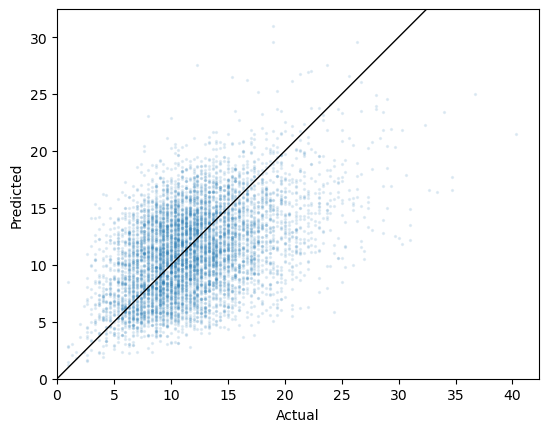

In [47]:
age_coeffs = np.array([1, 40, 50, 60, 70])
x_lists_age = np.array([df_stats['age_less65_proportion'], df_stats['age_65_proportion'], df_stats['age_70_proportion'], df_stats['age_75_proportion'], df_stats['age_over80_proportion']])

yhat = predict_admissions(x_lists_age, age_coeffs)

plot_y_vs_yhat(df_stats['admissions'], yhat)

Run those coeffs through the minimiser:

In [48]:
def main_age(coeffs, args):
    x_lists = args[0]
    admissions = args[1]
    yhat = predict_admissions(x_lists, coeffs)
    sum_sqres = find_square_residuals(yhat, admissions)
    return sum_sqres

In [49]:
args = [
    x_lists_age,
    df_stats['admissions']
]

opt_results = minimize(
    main_age,
    x0=age_coeffs,
    args=args,
    bounds=[(0.0, None)] * len(age_coeffs),
    method='Nelder-Mead'
)

Results:

In [50]:
opt_results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 106850.04290237506
             x: [ 6.723e+00  1.998e+01  0.000e+00  0.000e+00  1.048e+02]
           nit: 496
          nfev: 792
 final_simplex: (array([[ 6.723e+00,  1.998e+01, ...,  0.000e+00,
                         1.048e+02],
                       [ 6.723e+00,  1.998e+01, ...,  1.933e-10,
                         1.048e+02],
                       ...,
                       [ 6.723e+00,  1.998e+01, ...,  1.596e-10,
                         1.048e+02],
                       [ 6.723e+00,  1.998e+01, ...,  0.000e+00,
                         1.048e+02]]), array([ 1.069e+05,  1.069e+05,  1.069e+05,  1.069e+05,
                        1.069e+05,  1.069e+05]))

In [51]:
age_coeffs_opt = opt_results['x']

age_coeffs_opt

array([  6.72306978,  19.9760692 ,   0.        ,   0.        ,
       104.75843195])

Compare with results of the linear regression:

In [52]:
tab = [
    age_props,
    age_coeffs_lr,
    age_coeffs_opt
]

pl.DataFrame(tab, schema=['Variable', 'Linear regression', 'Optimiser'])

Variable,Linear regression,Optimiser
str,f64,f64
"""age_less65_proportion""",6.557996,6.72307
"""age_65_proportion""",35.445784,19.976069
"""age_70_proportion""",-15.72407,0.0
"""age_75_proportion""",-2.089421,0.0
"""age_over80_proportion""",109.276785,104.758432


Display fit:

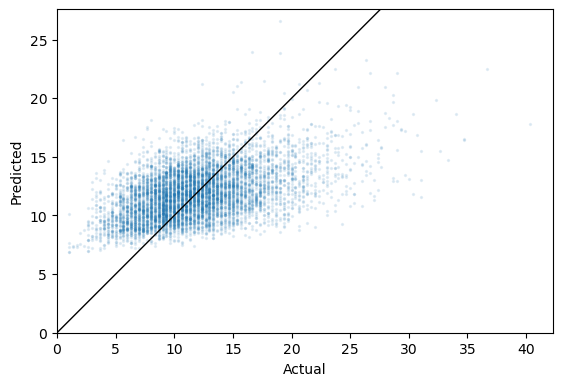

In [53]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)

plot_y_vs_yhat(df_stats['admissions'], yhat)

### IMD coefficients

Fix the age coeffs from above then add in the IMD coeff.

Manually change the coeff until there's something that resembles a fit to a straight line:

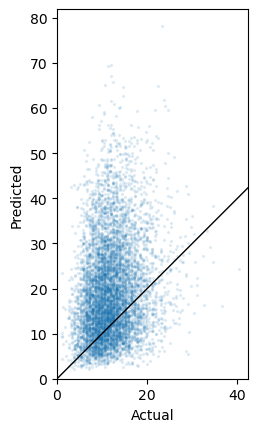

In [54]:
imd_coeffs = np.array([0.08])
x_lists_imd = np.array([df_stats['IMD2019Score']])

yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, imd_coeffs)

plot_y_vs_yhat(df_stats['admissions'], yhatdash)

Run those coeffs through the minimiser:

In [55]:
def main_imd(coeffs, args):
    x_lists_imd = args[0]
    admissions = args[1]
    yhat = args[2]

    yhatdash = yhat * predict_admissions(x_lists_imd, coeffs)
    
    sum_sqres = find_square_residuals(yhatdash, admissions)
    return sum_sqres

In [56]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)

args = [
    [df_stats['IMD2019Score']],
    df_stats['admissions'],
    yhat,
]

opt_results_imd = minimize(
    main_imd,
    x0=imd_coeffs,
    args=args,
    method='Nelder-Mead',
)#, bounds=[(0.0, None)] * len(imd_coeffs))

Results:

In [57]:
opt_results_imd

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 301810.0889783642
             x: [ 3.886e-02]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 3.886e-02],
                       [ 3.886e-02]]), array([ 3.018e+05,  3.018e+05]))

In [58]:
opt_coeffs_imd = opt_results_imd['x']

opt_coeffs_imd

array([0.03885742])

Compare with results of the linear regression:

In [59]:
props_cols = age_props + ['IMD2019Score']

pl.DataFrame(
    [props_cols, imd_age_coeffs_lr, np.concatenate((age_coeffs_opt, opt_coeffs_imd))],
    schema=['Variable', 'Linear regression', 'Iterative optimiser']
)

Variable,Linear regression,Iterative optimiser
str,f64,f64
"""age_less65_proportion""",2.936067,6.72307
"""age_65_proportion""",7.152629,19.976069
"""age_70_proportion""",7.419936,0.0
"""age_75_proportion""",8.033663,0.0
"""age_over80_proportion""",118.277084,104.758432
"""IMD2019Score""",0.107478,0.038857


Display fit:

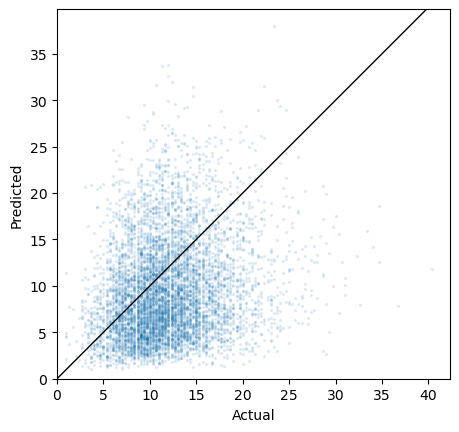

In [60]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

plot_y_vs_yhat(df_stats['admissions'], yhatdash)

### Health state coefficients

Fix the IMD and age coeffs from above then add in the health state coefficients.

Manually change the coeff until there's something that resembles a fit to a straight line:

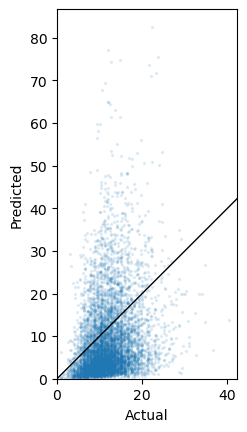

In [61]:
health_coeffs = np.array([5, 5, 5])
x_lists_health = np.array([df_stats['prop_good_health'], df_stats['prop_fair health'], df_stats['prop_bad health']])

yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

yhatdashdash = yhatdash.copy()
for i, x_list in enumerate(x_lists_health):
    coeff = health_coeffs[i]
    yhatdashdash = yhatdashdash * predict_admissions(np.array([x_list]), np.array([coeff]))

plot_y_vs_yhat(df_stats['admissions'], yhatdashdash)

Run those coeffs through the minimiser:

In [62]:
def main_health(coeffs, args):
    x_lists_health = args[0]
    admissions = args[1]
    yhatdash = args[2]

    yhatdashdash = yhatdash.copy()
    for i, x_list in enumerate(x_lists_health):
        coeff = coeffs[i]
        yhatdashdash = yhatdashdash * predict_admissions(np.array([x_list]), np.array([coeff]))
    
    sum_sqres = find_square_residuals(yhatdashdash, admissions)
    return sum_sqres

In [63]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

args = [
    [df_stats['prop_good_health'], df_stats['prop_fair health'], df_stats['prop_bad health']],
    df_stats['admissions'],
    yhatdash,
]

opt_results_health = minimize(
    main_health,
    x0=health_coeffs,
    args=args,
    method='Nelder-Mead',
)#, bounds=[(0.0, None)] * len(imd_coeffs))

Results

In [64]:
opt_results_health

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 544651.5173173213
             x: [ 5.365e+00  3.926e+00  4.223e+00]
           nit: 48
          nfev: 96
 final_simplex: (array([[ 5.365e+00,  3.926e+00,  4.223e+00],
                       [ 5.365e+00,  3.926e+00,  4.223e+00],
                       [ 5.365e+00,  3.926e+00,  4.223e+00],
                       [ 5.365e+00,  3.926e+00,  4.223e+00]]), array([ 5.447e+05,  5.447e+05,  5.447e+05,  5.447e+05]))

In [65]:
opt_coeffs_health = opt_results_health['x']

opt_coeffs_health

array([5.36459934, 3.92607403, 4.22274661])

Compare with results of the linear regression:

In [66]:
props_cols = age_props + [
    'IMD2019Score',
    'prop_good_health',
    'prop_fair health',
    'prop_bad health'
]

pl.DataFrame(
    [
        props_cols,
        health_imd_age_coeffs_lr,
        np.concatenate((age_coeffs_opt, opt_coeffs_imd, opt_coeffs_health))
    ],
    schema=['Variable', 'Linear regression', 'Iterative optimiser']
)

Variable,Linear regression,Iterative optimiser
str,f64,f64
"""age_less65_proportion""",321.938545,6.72307
"""age_65_proportion""",310.057476,19.976069
"""age_70_proportion""",324.251285,0.0
"""age_75_proportion""",303.290091,0.0
"""age_over80_proportion""",412.70686,104.758432
"""IMD2019Score""",-0.025573,0.038857
"""prop_good_health""",-321.015363,5.364599
"""prop_fair health""",-275.239194,3.926074
"""prop_bad health""",-285.86733,4.222747


Display fit:

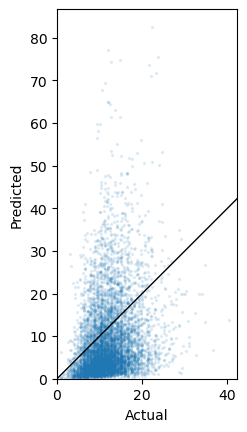

In [67]:
yhat = predict_admissions(x_lists_age, age_coeffs_opt)
yhatdash = yhat * predict_admissions(x_lists_imd, opt_coeffs_imd)

yhatdashdash = yhatdash.copy()
for i, x_list in enumerate(x_lists_health):
    coeff = health_coeffs[i]
    yhatdashdash = yhatdashdash * predict_admissions(np.array([x_list]), np.array([coeff]))

plot_y_vs_yhat(df_stats['admissions'], yhatdashdash)

## Calculate R-squared values

Function to calculate R-squared. This gives the same results as the sklearn built-in.

In [68]:
def calculate_rsquared(y, yhat):
    y_mean = y.mean()
    ss_res = ((yhat - y)**2.0).sum()
    ss_tot = ((y - y_mean)**2.0).sum()
    rsq = 1.0 - ss_res / ss_tot
    return rsq

Iterative fits:

In [69]:
rsq_age = calculate_rsquared(df_stats['admissions'], yhat)
rsq_imd_age = calculate_rsquared(df_stats['admissions'], yhatdash)
rsq_health_imd_age = calculate_rsquared(df_stats['admissions'], yhatdashdash)

Linear regression:

In [70]:
np.array([imd_age_coeffs_lr[-1]])

array([0.10747773])

In [71]:
yhat_lr = predict_admissions(x_lists_age, age_coeffs_lr)

yhatdash_lr = predict_admissions(np.concatenate((x_lists_age, x_lists_imd)), imd_age_coeffs_lr)


yhatdashdash_lr = predict_admissions(np.concatenate((x_lists_age, x_lists_imd, x_lists_health)), health_imd_age_coeffs_lr)

In [72]:
rsq_age_lr = calculate_rsquared(df_stats['admissions'], yhat_lr)
rsq_imd_age_lr = calculate_rsquared(df_stats['admissions'], yhatdash_lr)
rsq_health_imd_age_lr = calculate_rsquared(df_stats['admissions'], yhatdashdash_lr)

Display results:

In [73]:
tab = [
        ['Age', rsq_age_lr, rsq_age],
        ['IMD & age', rsq_imd_age_lr, rsq_imd_age],
        ['Health, IMD & age', rsq_health_imd_age_lr, rsq_health_imd_age]
    ]

pl.DataFrame(tab, schema=['Variables used', 'Linear regression', 'Iterative fits'], orient='row')

Variables used,Linear regression,Iterative fits
str,f64,f64
"""Age""",0.230116,0.229645
"""IMD & age""",0.307285,-1.175956
"""Health, IMD & age""",0.341279,-3.589684


## Comparison plots

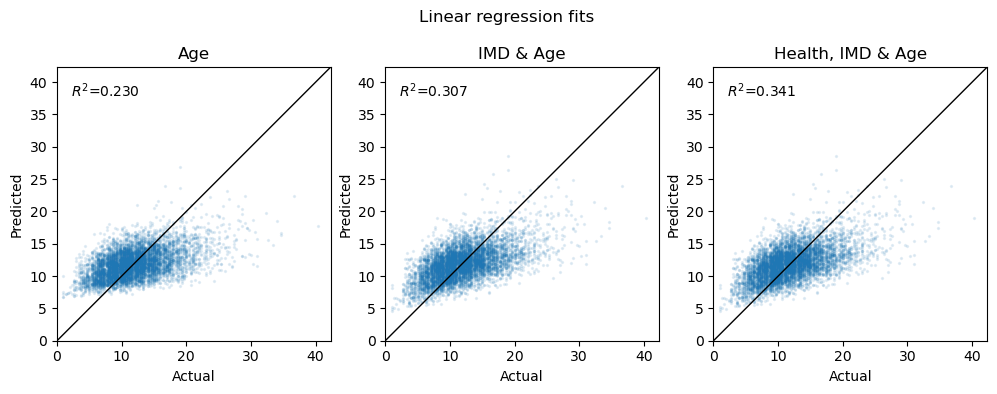

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Draw the data:
axs[0].scatter(y, yhat_lr, s=2, alpha=0.1)
axs[1].scatter(y, yhatdash_lr, s=2, alpha=0.1)
axs[2].scatter(y, yhatdash_lr, s=2, alpha=0.1)

# Find shared axis limits:
vmin = 10
vmax = 20
for ax in axs:
    ax.set_aspect('equal')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    vmin = min([vmin, xmin, ymin])
    vmax = max([vmax, xmax, ymax])
for ax in axs:
    # Draw a line diagonally:
    ax.plot([vmin, vmax], [vmin, vmax], color='k', linewidth=1)
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

axs[0].annotate(r'$R^{2}$=' + f'{rsq_age_lr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate(r'$R^{2}$=' + f'{rsq_imd_age_lr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'$R^{2}$=' + f'{rsq_health_imd_age_lr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

axs[0].set_title('Age')
axs[1].set_title('IMD & Age')
axs[2].set_title('Health, IMD & Age')

fig.suptitle('Linear regression fits')

plt.show()

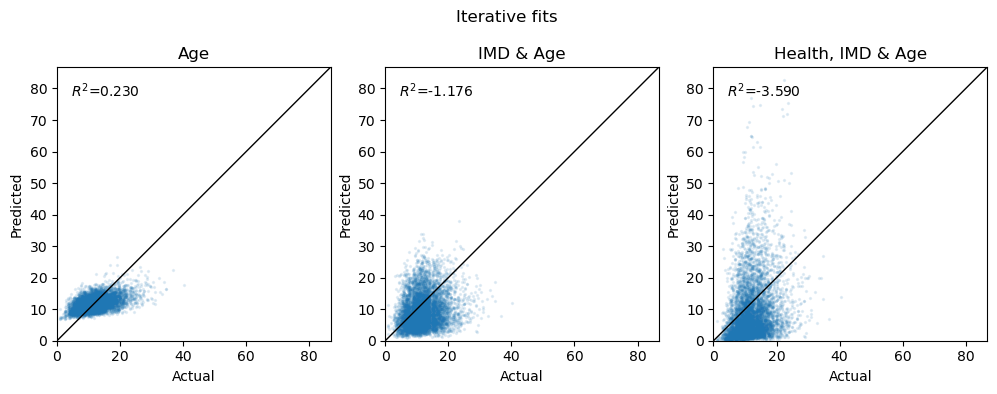

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Draw the data:
axs[0].scatter(y, yhat, s=2, alpha=0.1)
axs[1].scatter(y, yhatdash, s=2, alpha=0.1)
axs[2].scatter(y, yhatdashdash, s=2, alpha=0.1)

# Find shared axis limits:
vmin = 10
vmax = 20
for ax in axs:
    ax.set_aspect('equal')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    vmin = min([vmin, xmin, ymin])
    vmax = max([vmax, xmax, ymax])
for ax in axs:
    # Draw a line diagonally:
    ax.plot([vmin, vmax], [vmin, vmax], color='k', linewidth=1)
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

axs[0].annotate(r'$R^{2}$=' + f'{rsq_age:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate(r'$R^{2}$=' + f'{rsq_imd_age:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'$R^{2}$=' + f'{rsq_health_imd_age:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

axs[0].set_title('Age')
axs[1].set_title('IMD & Age')
axs[2].set_title('Health, IMD & Age')

fig.suptitle('Iterative fits')

plt.show()